(vqe)=

# Variational Quantum Eigensolver

В этой лекции мы рассмотрим такой классный и очень перспективный алгоритм как `Variational Quantum Eigensolver`. Это алгоритм, который создан для аппроксимационного решения задачи о собственных значениях матриц. Но, как мы увидим, к этой задаче можно свети большое число реально интересных задач, например, _NP_-трудные задачи комбинаторной оптимизации, о которых мы уже говорили в [лекции о квантовых алгоритмах](quantum_algorithms_overview).

Лекция будет построена следующим образом:

- Кратко вспомним задачу о собственных значениях
- Посмотрим, как эту задачу можно свести к градиентному спуску в пространстве параметров [параметризированной квантовой схемы](vqc)
- Поговорим о том, что такое гамильтониан Изинга
- Увидим, как задачи комбинаторной оптимизации сводятся к проблеме Изинга
- Полностью реализуем `VQE` и решим маленькую задачку Коммивояжера

## Задача о собственных значениях

Тем, кому этот блок сразу покажется трудным мы рекомендуем вернуться к вводным лекциям по линейной алгебре, а именно к [части про собственные вектора и собственные значения]().

Итак, пусть у нас есть диагонализируемая матрица $A$ размерности $n \times n$, она же является линейным оператором $\hat{A}$. Из линейной алгебры мы знаем, что у этой матрицы есть $n$ таких чисел $e_i$ и таких векторов $\Psi_i$, что для них выполняется условие:

$$
A \Psi_i = e_i \Psi_i
$$

или в нотации Дирака, которая используется в области квантовых вычисления:

$$
\hat{A} \ket{\Psi_i} = e_i\ket{\Psi_i}
$$

Таким образом, собственные вектора это такие вектора, которые при применении оператора не меняют свое направление. Например, если $A$ это, например, оператор поворота, то его собственные вектора, это его оси симметрии:

```{figure} /_static/vqeblock/vqe/Mona_Lisa.png
:width: 450px
:name: Mona_Lisa_Eigen

Синий вектор, в отличии от красного, при применении оператор не меняет направление так как является его собственным вектором.
```

### Алгоритмы нахождения собственных значений

В целом, задача нахождения собственных значений является очень трудной с вычислительной точки зрения, особенно для больших матриц. Для матриц размера более, чем $3 \times 3$ в общем случае не существует алгоритма нахождения собственных значений и собственных векторов. Однако существует несколько итеративных алгоритмов. Мы рассмотрим лишь два из них, причем без особых деталей, так как это эти алгоритмы, а также доказательство их сходимости являются достаточно сложными.

### Степенной метод

Один из самых простых для понимания алгоритмов, который, тем не менее находит интересные применения. Суть его в том, что мы берем некоторый случайный вектор $\ket{\Psi}$ и начинаем последовательно действовать на него оператором $\hat{A}$ (другими словами умножать на нашу матрицу), при этом нормируя на норму:

$$
\ket{\Psi_{i+1}} = \frac{\hat{A}\ket{\Psi_i}}{||\hat{A}||}
$$

И так мы повторяем до тех пор, пока изменения нашего вектора не будет меньше, чем некоторое заданное маленькое значение $\epsilon$. Когда мы достигли этого условия, это значит что мы нашли первый собственный вектор, который соответствует наибольшему собственному значению. В частном случае интересных нам эрмитовых операторов, можно также последовательно находить все собственные вектора и собственные значения.

```{note}
На самом деле, наша сеть интернет является графом -- множеством связанных между собой вершин. А любой граф можно представить в виде большой-большой, но очень разреженной матрицы, каждый элемент которой это 1 если между соответствующими вершинами есть ребро и 0, если нет. Например, элемент $L_{ij}$ будет 1, если между вершинами $i$ и $j$ есть ребро. В 1998-м году, Ларри Пейдж и Сергей Брин нашли очень эффективный способ как можно посчитать первый собственный вектор этой матрицы используя именно модификацию степенного метода. Этот алгоритм получил название `PageRank`, причем `Page` это именно фамилия автора, а не отсылка к веб-страницам. И именно этот алгоритм лег в основу поисковика _Google_, который в дальнейшем вырос в транснациональную корпорацию!
```

### Итерация Арнольди

Гораздо более сложный метод, который, однако, является одним из самых эффективных применительно к разреженным матрицам. Объяснить его легко, к сожалению, не получится, так как алгоритм требует понимания Крыловских подпространств и других концептов из области линейной алгебре разреженных систем. Но нам достаточно лишь того, что этот алгоритм имеет очень эффективную реализацию -- [ARPACK](https://www.caam.rice.edu/software/ARPACK/), написанную в середине 90-х годов на языке `FORTRAN77`. Именно эта библиотека используется "под капотом" у `SciPy`, а также во многих других научных пакетах. Давайте посмотрим, как она работает.

Сгенерируем большую разреженную матрицу.

In [1]:
import numpy as np
from scipy import sparse

np.random.seed(42)
x = np.random.random(10000)
np.random.seed(42)
y = np.random.random(10000)

px = np.where(x > 0.2)
py = np.where(y > 0.2)

num_elements = max([px[0].shape[0], py[0].shape[0]])

spmat = sparse.coo_matrix(
    (
        (np.ones(num_elements),
        (px[0][:num_elements], py[0][:num_elements]))
    )
)
print(spmat.__repr__())

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 7957 stored elements in COOrdinate format>


Матрица размера $10000 \times 10000$ это большая матрица и работать с ней в "плотном" (dense) представлении было бы очень трудно. Но `ARPACK` позволит нам найти минимальное собственное значение за доли секунд используя разреженность матрицы:

In [2]:
from scipy.sparse import linalg as sl

max_eigval = sl.eigs(spmat, k=1, which="LR", return_eigenvectors=False)[0]
min_eigval = sl.eigs(spmat, k=1, which="SR", return_eigenvectors=False)[0]

print(f"Min E: {min_eigval}\nMax E: {max_eigval}")

Min E: (-1.1102230246251565e-16+0j)
Max E: (1.0000000000000007+0j)


Для тех кто забыл, какие параметры принимает функция `eigs` из `scipy.linalg.spare` напомним, что первый параметр это разреженная матрица, второй параметр (`k`) это то, сколько именно собственных значений мы хотим получить. Параметр `which` указывает какие именно собственные значения мы хотим получить:

- `SM` -- _smallest magnitude_ -- наименьшие по модулю числа
- `LM` -- _largest magnitude_ -- наибольшие по модулю числа
- `SR` -- _smallers real_ -- числа с наименьшей действительной частью
- `LR` -- _largest real_ -- числа с наибольшей действительной частью
- `SI` -- _smallest image_ -- числа с наименьшей мнимой частью
- `LI` -- _largest image_ -- часла с наибольшей мнимой частью

Более подробна работа с `scipy.sparse`, а также с `scipy.sparse.linalg` разбирается в [вводном блоке по линейной алгебре](пока пусто).

```{note}
Не у всех матриц все собственные значения являются действительными, поэтому `ARPACK` по умолчанию считает нам комплексные значения, хотя в этом конкретном случае мы видим, что мнимая часть равна нулю.
```

В дальнейшем мы будем использовать `ARPACK`, вызывая его из `SciPy` для проверки того, что наш вариационный квантовый алгоритм нашел верное решение задачи.

## VQE

Теперь давайте посмотрим, как эта задача связана с квантовым компьютером, а также как ее можно свести к градиентному спуску в пространстве параметров `VQE`, содержащей лишь гейты вращения. Напомню, что наличие лишь гейтов вращения [позволяет нам эффективно считать градиенты](gradients).

### Собственные значения как результат измерения

Итак, у нас есть эрмитова матрица, для которой мы хотим найти минимальное собственное значение. То есть сделать примерно то, что делает `ARPACK`, но на квантовом компьютере.

```{note}
Если наша матрица $A$ не эрмитова, то мы всегда можем дополнить ее до эрмитовой. Поэтому далее, без потери общности, мы будем считать эту матрицу именно эрмитовой. Более подробно о том, как именно это можно сделать рассмотрено в [водных лекциях по линейной алгебре](пусто). Пока же нам достаточно знать, что это возможно.
```

Из первых лекций мы помним, что любое измерение квантового оператора в каком-то состоянии [есть проекция этого состояния на пространство его собственных векторов](../qcblock/qubit.html#id31), а результатом измерения [является одно из его собственных значений](../qcblock/qubit.html#id25). При этом распределение вероятностей получения этих собственных значений определяется нашей волновой функцией $\ket{\Psi}$ измеряемого состояния. А значит, то, какое собственное значение мы получим будет определяться тем, какое состояние мы приготовим! Более того, мы помним, что минимальное значения энергии, или минимальное собственное значение в терминах нашей задачи является наиболее вероятным результатом измерения основного состояния. Напомню, что мы записываем результат измерения оператора $\hat{A}$ в состоянии $\ket{\Psi}$ так:

$$
e = \bra{\Psi}\hat{A}\ket{\Psi}
$$

А, как мы помним из [лекции по параметризированным квантовым схемам](vqc) приготовленное состояние задается собственно самой схемой (еще говорят _ansatz_), а также набором ее классических параметров, которые варьируются в процессе обучения.

Так мы приходим к алгоритму `VQE` -- **V**ariational **Q**uantum **E**igensolver:

1. Выбираем _ansatz_ -- параметризированный оператор $\hat{B}(q)$, который представляет из себя последовательность гейтов вращения
2. Генерируем случайные начальные параметры $q_0$
3. Цикл обучения, повторяем $n$ раз
   1. Готовим состояние $\ket{\Psi} = \hat{B}(q_n)\ket{0}$
   2. Измеряем $e = \bra{\Psi}\hat{A}\ket{\Psi}$
   3. Вычисляем градиент $g = \frac{\partial{e}}{\partial{q}}$
   4. Обновляем параметры $q_{n+1} = q_n - \alpha g$
4. Результатом обучения являются:
   - Набор параметров $q$ такой, что $\hat{B}(q)\ket{0}$ является собственным вектором, близким к первому собственному вектору $\hat{A}$
   - Результат измерения $e$, близкий к первому собственному значению $\hat{A}$

## Гамильтониан Изинга

Хорошо, ну умеем мы находить первое собственное значение большой эрмитовой матрицы и соответствующий собственный вектор. А что нам с этого? Почему это так важно и этот алгоритм такой крутой?

На самом деле ответ в том, что огромное число задач реального мира, включая такие направления, как логистика, квантовая химия и даже анализ социальных сетей можно свести к задаче нахождения минимальной энергии специальной матрицы. Причем эта матрица ну прямо очень хорошо моделируется на квантовом компьютере! Это так называемый оператор Изинга или гамильтониан Изинга.

```{note}
Специальные квантовые компьютеры компании D-Wave сконструированы так, что они могут решать вообще только одну задачу -- нахождения основного состояния гамильтонианов типа Изинга. Но эта задача настолько распространена и важна, что эти компьютеры стали первыми в мире коммерческими квантовыми компьютерами! Кстати далее этим компьютерам у нас будет посвящена отдельная лекция.
```

Далее мы посвятим довольно много времени объяснению этой модели. Это может показаться скучным и занудным, но это важно для понимания того, как это все работает и как решать с помощью `VQE` реальные задачи!

### Задача Изинга в одномерном случае

```{note}
Ниже мы попробуем на пальцах объяснить модель Изинга. Пробовать мы будем через цепочку атомов ферромагнетика во внешнем магнитном поле. Ели вы плохо помните физику и вам это объяснение покажется сложным, то не расстраивайтесь -- дальше мы также объясним задачу Изинга как задачу о поиске максимального разреза в графе -- известную задачу комбинаторной оптимизации.
```

Пусть у нас есть, например, цепочка атомов, которые обладают магнитным моментом. Например, цепочка атомов ферромагнетика, такого как железо. И мы прикладываем к этой цепочке внешнее магнитное поле.

Тогда, если поле маленькое, то наши атомы будут стараться выстроиться в антиферромагнитный порядок, когда соседние из них имеют моменты, направленные в разные стороны. Но если поле уже большое, то оно будет стремиться "повернуть" моменты по своему направлению. А если еще вспомнить, что магнитный момент атома является квантовой величиной и может быть в суперпозиции состояний в одну сторону и в противоположную, то не очень маленькое, но и не слишком большое поле будет переводить часть атомов именно в такие суперпозиции.

```{figure} /_static/vqeblock/vqe/af_ordering.png
:width: 450px

Иллюстрация антиферромагнитного порядка
```

Давайте теперь запишем Гамильтониан такой системы. Для представления магнитных моментов мы будем использовать оператор $\sigma^z$ -- другими словами, спин в направлении оси $Z$. Если кто-то забыл, как выглядит оператор $\sigma^z$, то рекомендуем еще раз просмотреть [раздел про операторы Паули первой лекции](../qcblock/qubit.html#id24). Далее мы будем очень активно использовать эти матрицы для представления задач реального мира!

Для начала, в случае если внешнего поля нет, то мы должны записать взаимодействие соседних атомов. Так как у нас ферромагнетик, то минимальная энергия достигается в случае, если у нас спины противонаправленны. Это просто оператор $\sigma^z_j\sigma^z_{j+1}$, который действует на все пары соседних спинов. Ну и сразу введем некоторую константу обменного взаимодействия $J$, чтобы потом нам было удобно сравнивать ее с внешним полем. В итоге, для цепочки из $N$ спинов, получаем:

$$
\hat{H}_{h=0} = J \sum_{i=0}^{N-1} \sigma^{z}_i\sigma^{z}_{i+1}
$$

А теперь давайте добавим внешнее поле $h$. В этом случае, поле просто действует на все спины и пытается выстроить их, в зависимости от своего направления, например вниз. Тогда полный гамильтониан такой системы можно записать в виде:

$$
\hat{H}_{h\neq 0} = J \sum_{i=0}^{N-1} \sigma^{z}_i\sigma^{z}_{i+1} - h\sum_{i=0}^N \sigma^{z}_i
$$

### Задача Изинга как задача о максимальном разрезе в графе

Задача о максимальном разрезе в графе это очень известная задача комбинаторики. Она относится к классу $NP$-трудных и к ней можно свести все другие $NP$ задачи. При этом ее формулировка одна из самых простых среди всего класса задач. Формулируется она следующим образом.

Нам дан граф -- набор вершин $V$ и связывающих их ребер $E$. Нам надо найти такое разделение ребер $V$ на два не пересекающихся набора $V_1, V_2$, что число ребер между вершинами из разных наборов будет максимально.

```{figure} /_static/vqeblock/vqe/Max-cut.png
:width: 400px
:name: MaxCut

Иллюстрация задачи о максимальном разрезе в графе
```

Теперь давайте представим, что наши вершины графа мы моделируем спинами (ну или кубитами): спин "вверх" это, например, $V_1$, а спин "вниз" это $V_2$. Ну и для простоты предположим, что наш граф это просто цепочка, то есть ребра есть лишь между соседними в одномерном пространстве вершинами. Тогда легко записать функцию стоимости:

$$
H = \sum_{i=0}^{N-1} \sigma^{z}_i\sigma^{z}_{i+1}
$$

Ну и теперь давайте сформулируем нашу задачу чуточку сложнее -- нам надо найти не просто максимальный разрез, а такой разрез, который самый большой при наименьшем числе вершин в наборе $V_1$. Ну и, поскольку теперь у нас два вклада в стоимость, то нам нужны коэффициенты, которые покажут, что нам важнее. Пусть это будут $J$ и $h$. Финальная стоимость:

$$
H = J \sum_{i=0}^{N-1} \sigma^{z}_i\sigma^z_{i+1} - h\sum_{i=0}^N \sigma^{z}_i
$$

Мы и так как у нас собственные значения $\sigma^z$ это как раз $\pm 1$, то мы совершенно справедливо можем записать это все в виде гамильтониана:

$$
\hat{H} = J \sum_{i=0}^{N-1} \sigma^{z}_i\sigma^{z}_{i+1} - h\sum_{i=0}^N \sigma^{z}_i
$$

Как видно, это тот же самый гамильтониан, который мы получили и для моделирования ферромагнетиков.

```{note}
Одномерная цепочка атомов, ну или поиск максимального разреза в графе-цепочке является простым случаем и не является NP-задачей. Однако уже в двумерном случае эта задача становится сильно сложнее, как и, например, если в цепочке атомов ферромагнетика мы добавим взаимодействие не только соседних спинов, но и взаимодействие с соседями соседа. Аналогично, модель вида Изинга сильно усложняется при добавлении офф-диагональных элементов гамильтонинана, например, когда внешнее поле направлено в другом направлении и второй член гамильтониана принимает вид, например, $h\sum_{i=N} \sigma^{x}_i$. В рамках данной лекции мы не будем очень глубоко погружаться в исследование сложности и решений моделей Изинга, однако любопытный читатель может ознакомится с [продвинутой лекцией по этой теме](пусто).
```

### Модель Изинга на чистом NumPy

Давайте попробуем реализовать гамильтониан Изинга на чистом `NumPy`/`SciPy` в виде разреженной матрицы. Для этого вспомним [из первых лекций](qubit), что действуя оператором $\sigma^z$ на $i$ кубит мы одновременно действуем единичным оператором на все остальные, а потом перемножаем все операторы произведением Кронекера. Из [лекций по линейной алгебре](пусто) мы помним также об ассоциативности произведения Кронекера, чем и воспользуемся:

In [3]:
def sigmaz_k(k: int, n: int) -> sparse.csr_matrix:
    left_part = sparse.eye(2 ** k)
    right_part = sparse.eye(2 ** (n - 1 - k))

    return sparse.kron(
        sparse.kron(
            left_part,
            sparse.csr_matrix(np.array([[1, 0,], [0, -1,],]))
        ),
        right_part
    )

Ну а теперь мы можем реализовать и сам оператор Изинга:

In [4]:
def ising(j: float, h: float, n: int) -> sparse.csr_matrix:
    res = sparse.csr_matrix((2 ** n, 2 ** n), dtype=np.complex)

    for i in range(n - 1):
        res += j * sigmaz_k(i, n) * sigmaz_k(i + 1, n)
        res -= h * sigmaz_k(i, n)

    res -= h * sigmaz_k(n - 1, n)

    return res

Если внешнего поля нет, то наши спины выстраиваются в полный антиферромагнитный порядок, в чем легко убедиться. Создадим оператор для такой модели и, например, 10 спинов (или 10 вершин в графе, если мы говорим в терминах Max-Cut):

In [5]:
op = ising(1, 0, 10)
solution = sl.eigs(op, which="SR", k=1, return_eigenvectors=True)
print(f"Energy: {solution[0][0]}")

Energy: (-9.000000000000018-2.208468631860285e-16j)


Эта энергия соответствует антиферромагнитному порядку, в этом легко убедиться, нарисовав спины и формулу на бумажке. Внимательный читатель заметил, что в этот раз мы вернули также и первый собственный вектор, который в нашем случае является волновой функцией основного состояния. А, как мы помним, квадраты элементов вектора волновой функции дают нам вероятности соответствующих битовых строк (если для вас это все звучит дико, то очень рекомендуем вернуться к [лекции про кубит](qubit)). Давайте посмотрим на эту битовую строку, или, другими словами, на порядок наших спинов в решении (или на разбиение вершин графа на два подмножества в терминах Max-Cut):

In [6]:
def probs2bit_str(probs: np.array) -> str:
    size = int(np.log2(probs.shape[0]))
    bit_s_num = np.where(probs == probs.max())[0][0]
    s = f"{bit_s_num:b}"
    s = "0" * (size - len(s)) + s

    return s

probs = solution[1] * solution[1].conj()
print(probs2bit_str(probs))

0101010101


Теперь давайте попробуем добавить внешнее поле с коэффициентом, равным удвоенному значению константы обменного взаимодействия. В терминах комбинаторной задачи, мы добавляем штраф, равный два умножить на число спинов, направленных вверх.

In [7]:
op = ising(1, 2, 10)
solution = sl.eigs(op, which="SR", k=1, return_eigenvectors=True)
print(f"Energy: {solution[0][0]}")

probs = solution[1] * solution[1].conj()
print(probs2bit_str(probs))

Energy: (-10.99999999999999-1.0571225056728771e-16j)
0101010010


Видим, что теперь наш антиферромагнитный порядок уже не полный. В целом, данная модель довольно интересная, так как при некотором отношении $\frac{h}{J}$ у нас происходит фазовый переход от полной упорядоченности, а при дальнейшем росте $h$ мы приходим к полностью одинаковой ориентации всех спинов, в чем легко убедиться, взяв, например, $h = 100$:

In [8]:
op = ising(1, 100, 10)
solution = sl.eigs(op, which="SR", k=1, return_eigenvectors=True)
print(f"Energy: {solution[0][0]}")

probs = solution[1] * solution[1].conj()
print(probs2bit_str(probs))

Energy: (-991.0000000000039-3.4882612571137096e-14j)
0000000000


## Ну и причем тут _NP_-трудные задачи?

Мы потратили столько времени разбираясь с этой сложной антиферромагнитной моделью, а также совершенно оторванной от мира задачей о максимальном разрезе в графе. Теперь мы наконец-то увидим, что все это было не зря!

### Формулировка задач комбинаторной оптимизации в терминах гамильтониана Изинга

Мы уже рассмотрели привер того, как задачу комбинаторной оптимизации -- Max Cut -- можно свести к решению модели Изинга. Далее мы приведем примеры сведения некоторых интересных задач оптимизации к гамильтонианам этого типа. Все эти примеры мы будем брать из публикации {cite}`combinatorics2ising`. И перед тем, как мы начнем, нам понадобиться ввести еще одно определение, а именно оператор, у которого собственные вектора совпадают с таковыми у $\sigma^z$, а собственные значения равны 0 или 1 (вместо $\pm1$ для $\sigma^z$):

$$
\sigma^{z'} = (I + \sigma^z) / 2 = \begin{vmatrix} 1 & 0 \\
0 & 0 \end{vmatrix}
$$

Эта штука нам понадобиться, так как в комбинаторной оптимизации очень часто фигурируют именно такие "бинарные" переменные и с ними очень удобно работать. А теперь, поехали!

#### Задача о поиске Cliques в графах

_Тут будет описание_

#### Задача о выделении сообществ в графах

Задача о выделении сообщества в графах это очень важная и очень интересная задача. Она находит применение во многих областях, но одно из самых очевидных применений -- это социология (в том числе анализ социальных сетей), когда мы хотим анализируя контакты людей выделить из них сообщества для дальнейшего анализа. Эта задача также является $NP$-трудной, так как существует экспоненциально много способов разбить вершины на множества. Хотя для этой задачи и известны относительно быстрые приближенные алгоритмы, нам очень трудно понять, насколько хорошее решение они дают для действительно больших графов.

```{note}
Для работы с графами мы будем пользоваться библиотекой `NetworkX`. Она написана на чистом `Python` и плохо подходит для работы с большими графами, зато имеет простой интерфейс и легко устанавливается на любую систему. Ее можно установить из рерозитория `PyPI` используя команду `pip install networkx`. Подробнее о пакетах `Python` можно почитать в [одной из вводных лекций](python_l1) про этот язык программирования.
```

Одним из первых известных наборов данных для задачи выделения сообществ является "Клуб каратэ Захари" (Zachary’s Karate Club) {cite}`zachary1977`. Для этого набора данных точно известно, к какому из двух сообществ принадлежит какая из вершин. В этом клубе карате был внутренний конфликт и одна часть людей была в группе одного из инструкторов (Mr. Hi), а другая в группе администратора (Officer).

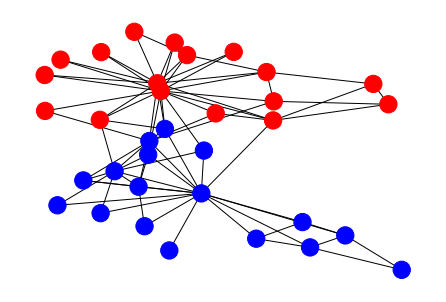

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

zachary = nx.generators.social.karate_club_graph()
nx.draw(
    zachary,
    node_color=[
        {"Officer": "r", "Mr. Hi": "b"}.get(dt["club"]) for _, dt
        in zachary.nodes(data=True)
    ],
)
plt.show()

На самом деле, задача о максимальном разрезе в графе является простейшим и тривиальным примером задачи о выделении сообществ в графе. И действительно, в случае, если в графе лишь два сообщества, то мы должны разбить все вершины на не перескающиеся подмножества. Правда в отличии от задачи о максимальном разрезе, в случае с сообществами мы хотим, что число ребер между ними было минимальным. Но это можно сделать просто поменяв знак в выражении для гамильтониана Изинга:

$$
\hat{H}_{communities} = - \sum_{e \in E} \sigma^z_{e_{srs}} \sigma^z_{e_{dst}}
$$

Тут $e \in E$ это значит суммирование по всем ребрам $e$ нашего графа, а $e_{src}$ и $e_{dst}$ это начальная и конечная вершины, которые соединяет ребро $e$.

Но, на самом деле, выбранная нами метрика (количество ребер) не самый лучший вариант для этой задачи. Гораздо лучше подойдет модулярность (modularity), предложенная физиком Марком Ньюманом {cite}`newman_modularity`:

$$
Q(C) = \frac{1}{2 |E|}\sum_{e \in E} B_{e_{src}, e_{dst}}\delta (c_{e_{src}}, c_{e_{dst}})
$$

Тут $B$ -- это матрица модулярности (modularity matrix). Ее элементы определяются через степени $d_i$ соответствующих вершин графа (степень вершины -- это число ребер, связанных с данной вершиной) и матрицу смежности $A$ графа:

$$
B_{ij} = A_ij - \frac{d_i d_j}{2 |E|}
$$

Условно, модулярность это разница между числом ребер внутри сообществ в нашем графе и числом ребер внутри сообществ в графе с таким же числом ребер, но сгенерированным случайным образом. Это довольно сложное понятие, которое выходит за рамки нашего курса, но все равно потребуется нам, чтобы показать, что задачи оптимизации модулярности может быть сформулирована как задача Изинга.

```{note}
Это интересно, но одним из первых алгоритмов для решения задачи о выделении сообществ в графах был алгоритм имитации отжига, который изначально был создан именно для решения проблемы гамильтонианов типа Изинга. Причина заключается в том, что модулярность очень схожа по виду с выражением энергии для ферромагнетика или антиферромагнетка.
```

_Тут формулировка модулярности в терминах изинга_

#### Задача о мостах Кеннингсберга (Калининграда)

_Текст_

```{figure} /_static/vqeblock/vqe/bridges.png
:width: 300px

Мосты Кеннингсберга, думая о которых Эйлер изобрел теорию графов
```

##### Оператор Изинга задачи о Гамильтоновых циклах

_Текст_

```{figure} /_static/vqeblock/vqe/Hamilton.jpg
:width: 350px

Сер Уильям Роуэн Гамильтон, 1805 - 1865
```

_Текст_

#### Задача коммивояжера

_Тут будет описание_

```{figure} /_static/intro1block/intro1/Salesman.png

Иллюстрация задачи коммивояжера
```

_Тут будет описание_

#### Задача о рюкзаке

_Тут будет описание_

## Решение задачи коммивояжера с помощью VQE

Итак, давайте попробуем решить задачу коммивояжера. Нам потребуется определить оператор $\sigma^{z_{mod}}$, который мы активно использовали при определении гамильтонинана, также расписать полный оператор, но для начала давайте сгенериуем случайный граф, с которым мы будем экспериментировать.

### Случайный взвешенный граф

Случайный взвешенный граф проще всего сгенерировать из случайной матрицы весов. Давайте сделаем такую:

```{note}
Тут мы будем работать с матрицей полного графа, то есть такого, в котором каждая вершина связана с каждой. Это вполне корректное допущение для задачи коммивояжера, так как, например, из каждого города РФ обычно можно попасть во все другие, пусть и за разное время в пути.
```

In [10]:
np.random.seed(42)
rand_mat = np.random.randint(0, 100, (4, 4))

Только эта матрица не является симметричной и имеет не нулевые элементы на диагонали. Элементы на диагонали означают петли (loop или self-loop), что не очень разумно в терминах задачи коммивояжера: не ясно, что значит, например, путь из Москвы в Москву. Аналогично и про то, что матрица не симметричная: если путь из Москвы в Санкт-Петербург займет 6 часов, то и путь обратно тоже займет столько же. Так что мы хотим симметричную матрицу. Давайте это исправим:

In [11]:
rand_adj = (rand_mat + rand_mat.T) / 2
np.fill_diagonal(rand_adj, 0)

Наконец, сделаем из этого граф и визуализируем его:

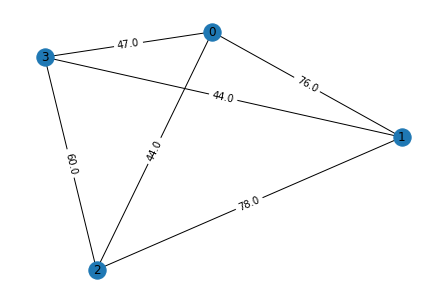

In [12]:
g = nx.Graph(rand_adj)

pos = nx.drawing.layout.random_layout(g, seed=42)
nx.draw(g, pos=pos)
edge_weights = nx.get_edge_attributes(g, "weight")
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_weights)
nx.draw_networkx_labels(g, pos=pos)
plt.show()

### Решение задачи TSP в NetworkX

Для того, чтобы потом понять, что мы все правильно сделали, давайте сразу найдем приближенное решение задачи средствами `NetworkX`.

In [13]:
nx_solution = nx.algorithms.approximation.traveling_salesman_problem(g)
nx_solution_cost = 0

for i in range(len(nx_solution) - 1):
    nx_solution_cost += g.get_edge_data(nx_solution[i], nx_solution[i + 1])["weight"]

print("NetworkX solution (nodes order):")
print(nx_solution)
print(f"NetworkX solution (total cost): {nx_solution_cost}")

NetworkX solution (nodes order):
[0, 3, 1, 2, 0]
NetworkX solution (total cost): 213.0


### Матрица $\sigma^z_{mod}$

In [14]:
def sigma_z_mod(k: int, size: int):
    sz_mod = sparse.coo_matrix(
        [
            [1, 0,],
            [0, 0,],
        ]
    )

    left_ith = sparse.eye(2 ** k, format="coo")
    right_ith = sparse.eye(2 ** (size - k - 1), format="coo")

    return sparse.kron(
        sparse.kron(left_ith, sz_mod),
        right_ith,
    )

Напомним, что эта матрица имеет собственные значения 0 и 1, в чем легко убедиться создав оператор маленькой размерности и вычислив все его собственные значения:

In [15]:
eigs = np.linalg.eig(sigma_z_mod(1, 3).toarray())
print(np.unique(eigs[0]))

[0. 1.]


Легко убедиться, что собственные операторы нашей $\sigma^{z_{mod}}$ совпадают с собственными операторами $\sigma^z$, причем они имеют значение 1, когда спин с номером 2 (напомню, что у нас 0-индексация, поэтому `sigma_z_mod(1, 3)` значит что-то типа "построй мне матрицу $\sigma^{z_{mod}}$, действующую на второй спин (ну или второй кубит)") имеет в битовой строке значение 0 и 1 если он имеет значение 1:

In [16]:
for i, psi in enumerate(eigs[1]):
    probs = psi * psi.conj()
    bit_s = probs2bit_str(probs)
    print(f"Eigenvalue: {eigs[0][i]}\tBit string: {bit_s}")

Eigenvalue: 1.0	Bit string: 000
Eigenvalue: 1.0	Bit string: 001
Eigenvalue: 0.0	Bit string: 010
Eigenvalue: 0.0	Bit string: 011
Eigenvalue: 1.0	Bit string: 100
Eigenvalue: 1.0	Bit string: 101
Eigenvalue: 0.0	Bit string: 110
Eigenvalue: 0.0	Bit string: 111


Убедимся также в совпадение собственных векторов с матрицей $\sigma^z$:

```{note}
Для чистых состояний без запутывания матрицы собственных векторов могут быть приведены к виду единичных матриц. И действительно, каждый собственный вектор отвечает строго одной конфигурации спинов, а значит его волновая функция имеет вид $\ket{\Psi} = \ket{0, 0, ..., 1, ..., 0, 0}$, где 1 соответствует как раз номеру той битовой строке, которая отвечает этой конфигурации.
```

In [17]:
print("Sigma z_mod:")
print(eigs[1])

print("Sigma z:")
print(np.linalg.eig(sigmaz_k(1, 3).toarray())[1])

Sigma z_mod:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Sigma z:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


### Гамильтониан

Давайте еще раз выпишем полный гамильтониан системы. Напомню, что наша задача будет параметризована при помощи $N^2$ кубит, которые, для удобства мы выстроим в виде матрицы, где $i$-я строка соответствует $i$-му шагу в цикле по графу, а $j$-й элемент строки соответствует номеру вершины и является нашим бинарным оператором:

$$
\hat{H} = a\sum_{i=1}^N (1 - \sum_{j=1}^N \sigma^{z_{mod}}_{i,j})^2 + a\sum_{j=1}^N (1 - \sum_{i=1}^N \sigma^{z_{mod}}_{i,j})^2 + a \sum_{u,v \not\in E}\sum_{j=1}^{N-1}\sigma^{z_{mod}}_{u,j}\sigma^{z_{mod}}_{v,j+1} + b \sum_{u,v \in E}\sum_{j=1}^{N-1}\sigma^{z_{mod}}_{u,j}\sigma^{z_{mod}}_{v,j+1}
$$

```{note}
Еще раз вспомним, что первые два слагаемых говорят нам, что каждая вершина должна входить только в один столбец, а каждая строка должна содержать только одну вершину. Третье слагаемое представляет собой штраф за соединение вершин, между которыми нет ребра, а четвертое дает нам стоимость всего пути. Первые три слагаемых идут с бОльшим коэффициентом, чем последнее, так как нам важно в первую очередь получить реальное решение, а не получить самое дешевое.
```

Но мы сделаем еще один небольшой финт. Мы будем всегда считать, что путь коммивояжера начинается в вершине с индексом 0. Так как путь коммивояжера это гамильтонов цикл, то мы делаем это упрощение без какой-либо потери общности, так как вершина с индексом 0 все равно должна будет войти в путь. При этом такой хитрый трюк позволит нам снизить число необходимых кубит с $N^2$ до $(N - 1)^2$, что довольно существенно (хотя ассимптотическая сложность остается такой же). Работать с графом мы будем при помощи уже знакомой нам библиотеки `NetworkX`:

In [18]:
def convert_tsp_to_ising(g: nx.Graph) -> sparse.coo_matrix:
    # У нас два элемента гамильтониана:
    #   - часть, дающая нам Гамилтонов цикл
    #   - часть, считающая стоимость пути
    # Для нас важно, чтобы вес первой части превалирвал.
    # Поэтому, в качестве коэффициента мы берем
    # пятикратное значение максимального веса ребер в графе.

    a = 5 * max([e[2]["weight"] for e in g.edges(data=True)])
    size = g.number_of_nodes() - 1

    H = sparse.coo_matrix((2 ** (size ** 2), 2 ** (size ** 2)), dtype=np.complex)

    # Вычисляем сумму по колонкам:
    #   - каждая вершина должна быть в каждой колонке строго один раз
    for i in range(size):
        # Считаем выражение 1 - sum
        col_sum = sparse.eye(2 ** (size ** 2), format="coo")
        for j in range(size):
            col_sum -= sigma_z_mod(i + j * size, size ** 2)

        # Возводим в квадрат и добавляем к гамилтониану
        H += a * col_sum * col_sum

    # Вычисляем сумму по строкам:
    #   - каждая вершина должна быть в каждой строке строго один раз
    for j in range(size):
        row_sum = sparse.eye(2 ** (size ** 2), format="coo")
        for i in range(size):
            row_sum -= sigma_z_mod(i + j * size, size ** 2)

        # Аналогично, в квадрат и добавляем
        H += a * row_sum * row_sum

    # Считаем сумму по тем ребрам, которых в графе нет и тем, которые есть.
    for i in range(size):
        for j in range(size):
            if g.has_edge(i + 1, j + 1):
                # Сумма по всем ребрам графа
                coef = g.get_edge_data(i + 1, j + 1)["weight"]
            else:
                # Сумма по всем отсутствующим ребрам графа
                coef = a

            for k in range(size - 1):
                # Дальше просто используем полученный коэффициент и считаем сумму
                H += (
                    coef
                    * sigma_z_mod(i + k * size, size ** 2)
                    * sigma_z_mod(j + (k + 1) * size, size ** 2)
                )

            H += (
                coef
                * sigma_z_mod(i + (size - 1) * size, size ** 2)
                * sigma_z_mod(j, size ** 2)
            )

    # Мы всегда начинаем из нулевой вершины, это позволяет нам снизить число необходимых кубитов.
    # Но теперь мы должны добавить в гамильтониан слагаемое, отвечающее за нулевую вершину в пути.
    for j in range(size):
        if g.has_edge(0, j + 1):
            coef = g.get_edge_data(0, j + 1)["weight"]
        else:
            coef = a

        H += coef * sigma_z_mod(j, size ** 2)
        H += coef * sigma_z_mod(j + (size - 1) * size, size ** 2)

    # PennyLane работает с матрицами только в координатном формате, поэтому сразу делаем приведение.
    return sparse.coo_matrix(H)

Давайте теперь проверим, что точное решение даст нам тот же путь (с той же стоимостью), что и решение из `NetworkX`:

In [19]:
op = convert_tsp_to_ising(g)
scipy_solution = sl.eigs(op, k=1, which="SR", return_eigenvectors=True)
print(f"Ground state energy: {scipy_solution[0][0]:.4f}")

probs = scipy_solution[1] * scipy_solution[1].conj()
bit_s = probs2bit_str(probs)

# Нулевая вершина всегда первая
scipy_path = [0,]

for i in range(3):
    k = 0
    for j in range(3):
        if bit_s[j + i * 3] == "0":
            k = j + 1
    scipy_path.append(k)
scipy_path.append(0)

scipy_solution_cost = 0
for i in range(len(scipy_path) - 1):
    scipy_solution_cost += g.get_edge_data(scipy_path[i], scipy_path[i + 1])["weight"]

print("SciPy solution (nodes order):")
print(scipy_path)
print(f"SciPy solution (total cost): {scipy_solution_cost}")

Ground state energy: 273.0000-0.0000j
SciPy solution (nodes order):
[0, 2, 1, 3, 0]
SciPy solution (total cost): 213.0


Мы видим, что решение через матрицу совпадает с тем, что нам выдал `NetworkX` (с точностью до инверсии: `[0, 2, 1, 3, 0]` и `[0, 3, 1, 2, 0]`), как и общая стоимость пути. Энергия основного состояния отличается по причине того, что мы использовали оптимизацию и магию с коэффициентами. Но это нам не важно: по энергиям нам важно лишь отношение порядка, потому что зная битовую строку мы всегда можем проверить стоимость пути за линейное время!

Теперь можно, наконец-то, приступать к симуляции квантовых вычислений!

#### VQE на Pennylane

Для начала давайте преобразуем нашу матрицу к тому объекту, с которым умеет работать наш квантовый фреймворк.

```{note}
`Pennylane` поддерживает также работу с представлением гамильтонианов в виде так называемых Паули-строк, но тут мы не будем еще раз определять весь гамильтониан, а просто перериспользуем нашу разреженную матрицу.
```

Веса нашего графа имеют разброс значений от 0 до 100. Из-за этого, при некоторых конфигурациях мы можем получать очень большое собственное значение нашего гамильтониана, вплоть до нескольких тысяч. Это не очень хорошо для градиентного спуска методом `paramter-shift`, поэтому для численной устойчивости давайте умножим все значения весов на $0.1$. Это сделает наши градиенты не слишком большими и улучшит численную сходимость:

In [20]:
import pennylane as qml

numer_stability_const = 0.1
ham = qml.SparseHamiltonian(op * numer_stability_const, wires=list(range(9)))

Далее нам необходимо выбрать _ansatz_. Современные квантовые процессоры обычно имеют вид решетки, типа такого:

```{figure} /_static/progblock/tfq/sycamore.png
:width: 350px
:name: sycamore_lattice

Изображение из {cite}`sycamore`
```

Поэтому нам, в идеале, хотелось бы делать либо одно-кубитные операции, либо двух-кубитные операции, но над "соседними" кубитами. Так появилась идея, так называемого, _hardware efficient ansatz_ {cite}`hardware_ansatz`. Он заключается в том, что мы формируем несколько "слоев" нашей **VQC**, каждый слой содержит несколько операций вращений, а также попарные "запутывающие" операции (например, [_CZ_](../qcblock/gates.html#cy-cz), или гейт [_CNOT_](../qcblock/gates.html#cnot-cx)). Выглядит это примерно так:

```{figure} /_static/vqeblock/vqe/HWA.png
:width: 400px

Иллюстрация _hardware efficient ansatz_ (_HWEA_) из {cite}`hardware_ansatz`
```

Давайте реализуем такой слой:

In [21]:
size = len(ham.wires)

def layer(params):
    for i in range(size):
        qml.RY(params[i][0], wires=i)
        qml.RZ(params[i][1], wires=i)

    for i in range(size - 1):
        qml.CZ(wires=[i, i + 1])

Здесь мы специально не повторяем основ параметризированных квантовых схем. Для тех, кто забыл, что это такое, рекомендуем вернуться к [отдельной лекции](vqc) по этой теме.

Теперь давайте создадим устройство, которое будет нашим квантовым симулятором, а также напишем код, который будет на этом устройстве запускаться. Такой код должен последовательно применить несколько наших _HWEA_ слоев, после чего измерить ожидаемое значение нашего гамильтониана в полученном состоянии.

In [22]:
device = qml.device("default.qubit", wires=size)
num_layers = 3

@qml.qnode(device, diff_method="parameter-shift")
def feed_forward(params, wires=size):
    for k in range(3):
        layer(params[k])

    for i in range(size):
        qml.RY(params[-1][i][0], wires=i)
        qml.RZ(params[-1][i][1], wires=i)

    return qml.expval(ham)

Теперь нам надо сгенерировать параметры и выбрать метод их оптимизации. В этот раз давайте воспользуемся алгоритмом `Momentum`, так называемым "ускоренным" градиентным спуском:

In [23]:
opt = qml.MomentumOptimizer()
params = tuple(
    tuple(
        (
            np.random.rand() * 2 * np.pi,
            np.random.rand() * 2 * np.pi,
        )
        for _ in range(size)
    )
    for _ in range(num_layers + 1)
)

Ну и наконец можно приступать к оптимизации параметров. Все примерно также, как в [базовой лекции про градиенты](gradients). То есть ничего нового мы тут по сути не делаем.

```{warning}
Осторожно, следующий код работает несколько минут, так как мы обучаем довольно тяжелую схему на 9-и кубитах!
```

In [24]:
energy = [
    feed_forward(params),
]

for epoch in range(150):
    params, e = opt.step_and_cost(feed_forward, params)
    energy.append(e)

    if epoch % 10 == 0:
        print(f"epoch: {epoch}\tenergy: {e:.6f}")

epoch: 0	energy: 360.638506


epoch: 10	energy: 96.375950


epoch: 20	energy: 43.497589


epoch: 30	energy: 31.882151


epoch: 40	energy: 29.232270


epoch: 50	energy: 27.814023


epoch: 60	energy: 27.479515


epoch: 70	energy: 27.348231


epoch: 80	energy: 27.324815


epoch: 90	energy: 27.307322


epoch: 100	energy: 27.303441


epoch: 110	energy: 27.300767


epoch: 120	energy: 27.300371


epoch: 130	energy: 27.300139


epoch: 140	energy: 27.300076


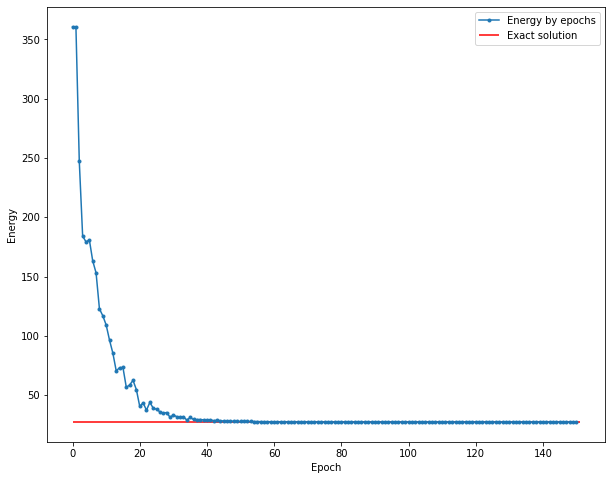

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(energy)), energy, ".-", label="Energy by epochs")
plt.hlines(
    np.real(scipy_solution[0][0]) * numer_stability_const,
    0,
    len(energy),
    color="red",
    label="Exact solution",
)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.legend()
plt.show()

Видим, что наш **VQE** отлично сходится к основному состоянию, которое мы знаем из `SciPy` и `ARPACK`. Теперь давайте убедимся, что квантовый путь совпадет с тем, что мы получили из `NetworkX`. Для этого нам нужно получить распределение вероятностей битовых строк. На реальном компьютере это можно сделать просто измеряя много раз, но на симуляторе у нас есть возможность получить его сразу одной командой.

In [26]:
@qml.qnode(device, diff_method="parameter-shift")
def answer(params, wires=size):
    for k in range(num_layers):
        layer(params[k])

    for i in range(size):
        qml.RY(params[-1][i][0], wires=i)
        qml.RZ(params[-1][i][1], wires=i)

    return qml.probs(wires=list(range(size)))

probs = answer(params)
bit_s = probs2bit_str(probs)

# Нулевая вершина всегда первая
q_path = [0,]

for i in range(3):
    k = 0
    for j in range(3):
        if bit_s[j + i * 3] == "0":
            k = j + 1
    q_path.append(k)
q_path.append(0)

q_solution_cost = 0
for i in range(len(q_path) - 1):
    q_solution_cost += g.get_edge_data(q_path[i], q_path[i + 1])["weight"]

print("Quantum solution (nodes order):")
print(q_path)
print(f"Quantum solution (total cost): {q_solution_cost}")

Quantum solution (nodes order):
[0, 2, 1, 3, 0]
Quantum solution (total cost): 213.0


Ура, у нас получился тот же ответ, что и в `SciPy`/`NetworkX`. Значит наш самописный **VQE** работает правильно.

## Заключение

В будущем вам вряд-ли придется самим расписывать матрицы и строить гамильтонианы, так как большинство современных квантовых фреймворков имеют встроенные рутины для самых типичных задач комбинаторной оптимизации. Однако для полного понимания того, как **VQE** работает внутри нам просто необходимо было проделать это все от начала и до конца самим. Надеюсь вам было интересно и не слишком сложно!